# Entropy Reward Diagnostics

Use this notebook to stress-test whether per-step entropy is a clean teaching signal for Sudoku.
We compare a classical (solution-guided) solver vs. our RL agent across difficulty bins
and look at entropy trajectories and deltas.

In [ ]:
# If you need plotting libs inside the poetry env, uncomment:
# %pip install matplotlib seaborn

## Imports & paths

In [7]:
import json
import math
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

from sudoku_rl.env import SudokuEnv, board_entropy, candidate_count, _masks_from_board
from sudoku_rl.puzzle import sample_puzzle, supported_bins
from sudoku_rl.sudoku_mlp import SudokuMLP

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
torch.manual_seed(0)

print(f"Using device: {DEVICE}")
print(f"Available bins: {supported_bins()}")
from sudoku_rl.solver_norvig import solve_with_trace
from sudoku_rl.distance_regressor import DistanceRegressor, generate_distance_examples, DistanceDataset, evaluate, train_regressor, spearmanr, IsotonicCalibrator
import importlib
import sudoku_rl.distance_regressor as dr
dr = importlib.reload(dr)


Using device: cpu
Available bins: ('zeros_04_07', 'zeros_08_11', 'zeros_12_15', 'zeros_16_19', 'zeros_20_23', 'zeros_24_27', 'zeros_28_31', 'zeros_32_35', 'zeros_36_39', 'zeros_40_43', 'zeros_44_47', 'zeros_48_51', 'zeros_52_55', 'zeros_56_59')


## Configure experiment

Buckets are keyed by number of zeros; tweak these or the sample counts/checkpoint path as needed.

In [8]:
from pathlib import Path

# Difficulty buckets we want to probe (roughly up to ~50 blanks)
BIN_LABELS = [
    "zeros_12_15",
    "zeros_24_27",
    "zeros_32_35",
    "zeros_44_47",
    "zeros_48_51",
]

# How many puzzles/episodes per bucket
PUZZLES_PER_BIN = 30   # oracle sweep
EPISODES_PER_BIN = 25  # RL sweep

# Interpolation resolution for averaging trajectories
INTERP_POINTS = 101

# Max steps allowed for the RL agent when rolling out
MAX_STEPS = 400

def find_project_root(start: Path, marker="experiments"):
    cur = start.resolve()
    for parent in (cur, *cur.parents):
        if (parent / marker).exists():
            return parent
    raise RuntimeError("Could not locate project root containing: " + marker)

PROJECT_ROOT = find_project_root(Path.cwd())
MODEL_PATH = PROJECT_ROOT / "experiments" / "last_entropy_run" / "model_000200.pt"

# Match the environment's entropy shaping
ENTROPY_WEIGHT = SudokuEnv.ENTROPY_EMPTY_WEIGHT
print("Using entropy empty weight =", ENTROPY_WEIGHT)

Using entropy empty weight = 0.5


## Helper functions

In [9]:
from typing import List, Dict


def solution_guided_oracle(initial_board, solution_board, entropy_weight: float = ENTROPY_WEIGHT) -> np.ndarray:
    'Fill cells using the ground-truth solution, choosing the next cell with the fewest candidates.'
    board = np.array(initial_board, dtype=np.int8, copy=True)
    solution = np.array(solution_board, dtype=np.int8, copy=False)

    entropies = [board_entropy(board, entropy_empty_weight=entropy_weight)]

    while (board == 0).any():
        masks = _masks_from_board(board)
        empties = np.argwhere(board == 0)
        if len(empties) == 0:
            break

        counts = [
            candidate_count(board, int(r), int(c), masks=(masks[0], masks[1], masks[3]))
            for r, c in empties
        ]
        best_idx = int(np.argmin(counts))
        r, c = map(int, empties[best_idx])
        board[r, c] = int(solution[r, c])
        entropies.append(board_entropy(board, entropy_empty_weight=entropy_weight))

    return np.asarray(entropies, dtype=float)


def interp_series(values: np.ndarray, num_points: int = INTERP_POINTS):
    arr = np.asarray(values, dtype=float)
    if arr.size == 1:
        arr = np.array([arr[0], arr[0]], dtype=float)

    t_src = np.linspace(0.0, 1.0, arr.size)
    t_tgt = np.linspace(0.0, 1.0, num_points)
    ent = np.interp(t_tgt, t_src, arr)
    delta = ent[:-1] - ent[1:]
    delta = np.concatenate([delta, [0.0]])
    return t_tgt, ent, delta


def aggregate_oracle_bin(bin_label: str, n_samples: int = PUZZLES_PER_BIN) -> Dict[str, np.ndarray]:
    ent_stack, delta_stack = [], []
    for seed in range(n_samples):
        puzzle, solution = sample_puzzle(bin_label=bin_label, seed=seed, return_solution=True, prev_mix_ratio=0.0)
        ent = solution_guided_oracle(puzzle, solution)
        if not np.isfinite(ent).all():
            continue
        _, ent_i, delta_i = interp_series(ent)
        ent_stack.append(ent_i)
        delta_stack.append(delta_i)

    if len(ent_stack) == 0:
        raise ValueError(f"No finite oracle traces for {bin_label}")

    ent_stack = np.stack(ent_stack)
    delta_stack = np.stack(delta_stack)
    timeline = np.linspace(0.0, 1.0, INTERP_POINTS)
    return {
        "time": timeline,
        "entropy_mean": ent_stack.mean(axis=0),
        "entropy_std": ent_stack.std(axis=0),
        "delta_mean": delta_stack.mean(axis=0),
        "delta_std": delta_stack.std(axis=0),
        "n": ent_stack.shape[0],
    }


def build_policy(model_path: Path = MODEL_PATH, device=DEVICE):
    if not model_path.exists():
        raise FileNotFoundError(f"Checkpoint not found: {model_path}")

    from gymnasium import spaces

    class DummyEnv:
        single_observation_space = spaces.Box(low=0, high=9, shape=(81,), dtype=np.int8)
        single_action_space = spaces.Discrete(9 * 9 * 9)

    policy = SudokuMLP(DummyEnv(), use_action_mask=True).to(device)
    state = torch.load(model_path, map_location=device, weights_only=False)
    policy.load_state_dict(state)
    policy.eval()
    return policy


def run_agent_episode(policy, bin_label: str, seed: int, greedy: bool = True, max_steps: int = MAX_STEPS):
    puzzle, solution = sample_puzzle(bin_label=bin_label, seed=seed, return_solution=True, prev_mix_ratio=0.0)
    env = SudokuEnv(puzzle, solution, max_steps=max_steps)
    obs = env.reset(initial_board=puzzle, solution_board=solution)

    entropies = [env.entropy]
    deltas: List[float] = []
    info = {}

    for _ in range(max_steps):
        obs_flat = torch.as_tensor(obs.reshape(1, -1), dtype=torch.float32, device=DEVICE)
        with torch.no_grad():
            logits, _ = policy.forward_eval(obs_flat)
            if greedy:
                action = torch.argmax(logits, dim=1)
            else:
                dist = torch.distributions.Categorical(logits=logits)
                action = dist.sample()
        obs, reward, done, info = env.step(int(action.item()))
        entropies.append(info["entropy_after"])
        deltas.append(info["entropy_delta"])
        if done:
            break

    solved = bool(info.get("solved", False))
    timeout = bool(info.get("timeout", False)) or (env.steps >= max_steps)

    return {
        "entropies": np.asarray(entropies, dtype=float),
        "entropy_deltas": np.asarray(deltas, dtype=float),
        "solved": solved,
        "timeout": timeout,
        "wrong_digit": bool(info.get("wrong_digit", False)),
        "steps": env.steps,
    }


def aggregate_agent_bin(policy, bin_label: str, episodes: int = EPISODES_PER_BIN, greedy: bool = True):
    timeline = np.linspace(0.0, 1.0, INTERP_POINTS)
    success_ent, fail_ent, success_delta, fail_delta = [], [], [], []
    cumulative_rows = []

    for seed in range(episodes):
        ep = run_agent_episode(policy, bin_label, seed=seed, greedy=greedy, max_steps=MAX_STEPS)
        _, ent_i, delta_i = interp_series(ep["entropies"])
        target_ent = success_ent if ep["solved"] else fail_ent
        target_delta = success_delta if ep["solved"] else fail_delta
        target_ent.append(ent_i)
        target_delta.append(delta_i)

        cumulative_rows.append({
            "bin": bin_label,
            "solved": ep["solved"],
            "cum_entropy_delta": float(np.sum(ep["entropy_deltas"])),
            "steps": ep["steps"],
            "timeout": ep["timeout"],
            "wrong_digit": ep["wrong_digit"],
        })

    def _summary(stack):
        if not stack:
            return None
        arr = np.stack(stack)
        return {"mean": arr.mean(axis=0), "std": arr.std(axis=0), "n": arr.shape[0]}

    return {
        "time": timeline,
        "success": _summary(success_ent),
        "failure": _summary(fail_ent),
        "delta_success": _summary(success_delta),
        "delta_failure": _summary(fail_delta),
        "cumulative": pd.DataFrame(cumulative_rows),
    }

## Reward-scaling sandbox

Estimate typical entropy range per bin so we can scale `WRONG_DIGIT_PENALTY`, `SOLVE_BONUS`, etc., relative to the expected entropy drop per correct move. This gives us a data-backed target before editing `env.py`.

In [10]:
from sudoku_rl.env import SudokuEnv

WRONG_PENALTY = SudokuEnv.WRONG_DIGIT_PENALTY
SOLVE_BONUS = SudokuEnv.SOLVE_BONUS

def entropy_stats(bin_label, samples=50):
    ent, empties = [], []
    for seed in range(samples):
        puzzle, solution = sample_puzzle(bin_label=bin_label, seed=seed, return_solution=True, prev_mix_ratio=0.0)
        env = SudokuEnv(puzzle, solution, max_steps=1)
        ent.append(env.entropy)
        empties.append(env.initial_empties)
    ent = np.array(ent, float)
    empties = np.array(empties, float)
    mean_drop_per_move = ent / np.maximum(empties, 1)
    return {
        "mean_start_entropy": ent.mean(),
        "std_start_entropy": ent.std(),
        "mean_empties": empties.mean(),
        "mean_drop_per_move": mean_drop_per_move.mean(),
        "median_drop_per_move": np.median(mean_drop_per_move),
    }

reward_scan = []
for b in BIN_LABELS:
    stats = entropy_stats(b, samples=30)
    stats["bin"] = b
    stats["wrong_penalty/current"] = WRONG_PENALTY
    stats["wrong_penalty/as_mean_drop_x3"] = 3 * stats["mean_drop_per_move"]
    stats["solve_bonus/current"] = SOLVE_BONUS
    stats["solve_bonus/as_total_entropy"] = stats["mean_start_entropy"]
    reward_scan.append(stats)

reward_df = pd.DataFrame(reward_scan)[[
    "bin",
    "mean_start_entropy",
    "std_start_entropy",
    "mean_empties",
    "mean_drop_per_move",
    "median_drop_per_move",
    "wrong_penalty/current",
    "wrong_penalty/as_mean_drop_x3",
    "solve_bonus/current",
    "solve_bonus/as_total_entropy",
]]
reward_df

,bin,mean_start_entropy,std_start_entropy,mean_empties,mean_drop_per_move,median_drop_per_move,wrong_penalty/current,wrong_penalty/as_mean_drop_x3,solve_bonus/current,solve_bonus/as_total_entropy
0,zeros_12_15,9.005103,1.142224,14.066667,0.638775,0.643580,3.0,1.916324,10.0,9.005103
1,zeros_24_27,21.555000,2.988801,26.000000,0.827771,0.846783,3.0,2.483313,10.0,21.555000
2,zeros_32_35,35.742048,3.283388,33.900000,1.054103,1.054711,3.0,3.162310,10.0,35.742048
3,zeros_44_47,66.326458,4.809838,45.700000,1.450192,1.439966,3.0,4.350576,10.0,66.326458
4,zeros_48_51,77.194377,4.880335,49.233333,1.566806,1.551496,3.0,4.700419,10.0,77.194377


## 1) Oracle entropy traces

In [11]:
oracle_results = {}
for b in tqdm(BIN_LABELS, desc="oracle bins"):
    oracle_results[b] = aggregate_oracle_bin(b)

oracle_df = pd.concat([
    pd.DataFrame({
        "time": res["time"],
        "entropy_mean": res["entropy_mean"],
        "entropy_std": res["entropy_std"],
        "delta_mean": res["delta_mean"],
        "delta_std": res["delta_std"],
        "bin": b,
        "n": res["n"],
    })
    for b, res in oracle_results.items()
], ignore_index=True)

oracle_df.head()

oracle bins:   0%|          | 0/5 [00:00<?, ?it/s]

,time,entropy_mean,entropy_std,delta_mean,delta_std,bin,n
0,0.00,9.005103,1.142224,0.143524,0.076835,zeros_12_15,30
1,0.01,8.861579,1.116070,0.143524,0.076835,zeros_12_15,30
2,0.02,8.718055,1.094695,0.143524,0.076835,zeros_12_15,30
3,0.03,8.574531,1.078382,0.143524,0.076835,zeros_12_15,30
4,0.04,8.431007,1.067364,0.143524,0.076835,zeros_12_15,30


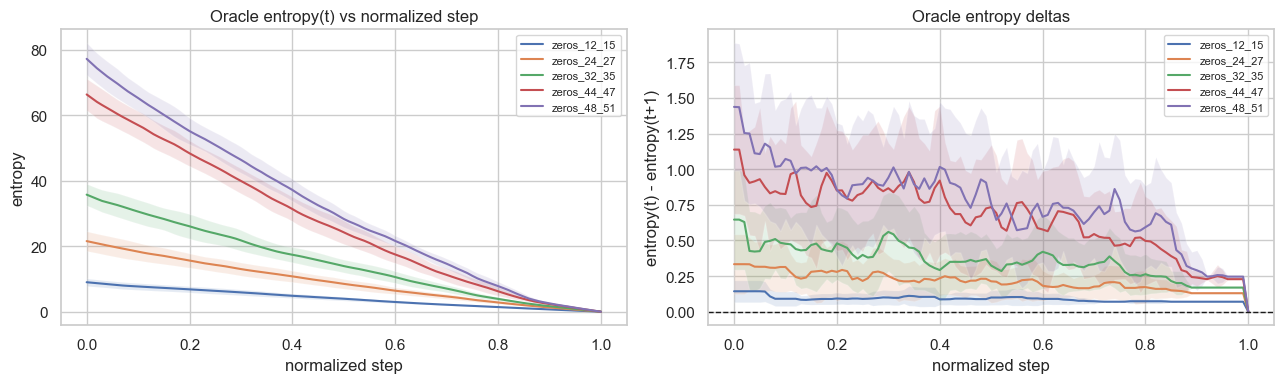

In [12]:
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_theme(style="whitegrid")

    fig, axes = plt.subplots(1, 2, figsize=(13, 4))

    for b, res in oracle_results.items():
        axes[0].plot(res["time"], res["entropy_mean"], label=b)
        axes[0].fill_between(res["time"], res["entropy_mean"] - res["entropy_std"], res["entropy_mean"] + res["entropy_std"], alpha=0.15)
    axes[0].set_title("Oracle entropy(t) vs normalized step")
    axes[0].set_xlabel("normalized step")
    axes[0].set_ylabel("entropy")
    axes[0].legend(loc="upper right", fontsize=8)

    for b, res in oracle_results.items():
        axes[1].plot(res["time"], res["delta_mean"], label=b)
        axes[1].fill_between(res["time"], res["delta_mean"] - res["delta_std"], res["delta_mean"] + res["delta_std"], alpha=0.15)
    axes[1].axhline(0, color="k", lw=1, ls="--")
    axes[1].set_title("Oracle entropy deltas")
    axes[1].set_xlabel("normalized step")
    axes[1].set_ylabel("entropy(t) - entropy(t+1)")
    axes[1].legend(loc="upper right", fontsize=8)

    plt.tight_layout()
    plt.show()
except ImportError:
    print("Install matplotlib + seaborn to see plots.")

## 2) RL agent entropy traces

In [13]:
policy = build_policy(MODEL_PATH)
policy

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 policy = build_policy(MODEL_PATH)                                                            │
│   2 policy                                                                                       │
│   3                                                                                              │
│                                                                                                  │
│ in build_policy:71                                                                               │
│                                                                                                  │
│    68                                                                                            │
│    69 def build_policy(model_path: Path = MODEL_PATH, device=DEVICE):                            │
│    70 │   if not model_path.exists():                                                            │
│ ❱  71 │   │   raise FileNotFoundError(f"Checkpoint not found: {model_path}")                     │
│    72 │                                                                                          │
│    73 │   from gymnasium import spaces                                                           │
│    74                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
FileNotFoundError: Checkpoint not found: 
/Users/santi/Documents/dev/sandbox/sudoku_rl/notebooks/experiments/last_entropy_run/model_000200.pt

In [ ]:
agent_results = {}
for b in tqdm(BIN_LABELS, desc="agent bins"):
    agent_results[b] = aggregate_agent_bin(policy, b, episodes=EPISODES_PER_BIN, greedy=True)

cum_df = pd.concat([res["cumulative"] for res in agent_results.values()], ignore_index=True)
print("Episodes per bin (success/failure):")
print(cum_df.groupby(["bin", "solved"]).size())

cum_summary = cum_df.groupby(["bin", "solved"]).agg(
    episodes=("cum_entropy_delta", "count"),
    mean_cum_entropy_delta=("cum_entropy_delta", "mean"),
    median_cum_entropy_delta=("cum_entropy_delta", "median"),
)
cum_summary

In [ ]:
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_theme(style="whitegrid")
except ImportError:
    plt = None

if plt is None:
    print("Install matplotlib + seaborn to see agent plots.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))

    for b, res in agent_results.items():
        if res["success"] is not None:
            axes[0].plot(res["time"], res["success"]["mean"], label=f"{b} success", linestyle="solid")
            axes[0].fill_between(res["time"], res["success"]["mean"] - res["success"]["std"], res["success"]["mean"] + res["success"]["std"], alpha=0.1)
        if res["failure"] is not None:
            axes[0].plot(res["time"], res["failure"]["mean"], label=f"{b} failure", linestyle="dashed")
    axes[0].set_title("RL agent entropy(t)")
    axes[0].set_xlabel("normalized step")
    axes[0].set_ylabel("entropy")
    axes[0].legend(loc="upper right", fontsize=7)

    for b, res in agent_results.items():
        if res["delta_success"] is not None:
            axes[1].plot(res["time"], res["delta_success"]["mean"], label=f"{b} success", linestyle="solid")
        if res["delta_failure"] is not None:
            axes[1].plot(res["time"], res["delta_failure"]["mean"], label=f"{b} failure", linestyle="dashed")
    axes[1].axhline(0, color="k", lw=1, ls="--")
    axes[1].set_title("RL agent entropy deltas")
    axes[1].set_xlabel("normalized step")
    axes[1].set_ylabel("entropy(t) - entropy(t+1)")
    axes[1].legend(loc="upper right", fontsize=7)

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(6, 4))
    cum_df = pd.concat([res["cumulative"] for res in agent_results.values()], ignore_index=True)
    cum_df["label"] = np.where(cum_df["solved"], "success", "failure")
    sns.boxplot(data=cum_df, x="label", y="cum_entropy_delta", ax=ax)
    ax.axhline(0, color="k", lw=1, ls="--")
    ax.set_title("Cumulative entropy delta per episode")
    plt.show()

## Reading the outputs

- If oracle entropy steadily falls (negative deltas early, near-zero late), entropy is a good progress proxy.
- If agent success curves mirror the oracle while failures stall/oscillate, entropy is giving a usable signal.
- If successes and failures look similar or deltas wander around zero, entropy-only rewards are weak; consider mixing in legality bonuses, step penalties, or curriculum tweaks instead of tuning PPO hyperparams alone.

## Distance-to-Solve regressor checks

Use the classical solver traces to learn \hat{D}(s) (steps remaining), then compare Δ\hat{D} against entropy on solver and agent trajectories.

In [17]:
DIST_MODEL_PATH = Path("experiments/distance_regressor.pt")

def load_or_train_dist_model():
    if DIST_MODEL_PATH.exists():
        ckpt = torch.load(DIST_MODEL_PATH, map_location=DEVICE, weights_only=False)
        model = DistanceRegressor().to(DEVICE)
        model.load_state_dict(ckpt["model_state_dict"])
        model.eval()
        print("Loaded distance regressor from", DIST_MODEL_PATH)
        print("Saved metrics", ckpt.get("metrics"))
        return model
    # Fallback: train a tiny model for demo (small sample to keep runtime short in the notebook)
    small_bins = BIN_LABELS[:3]
    examples = generate_distance_examples(small_bins, puzzles_per_bin=30, seed_offset=0)
    rng = np.random.default_rng(0)
    rng.shuffle(examples)
    split = int(0.8 * len(examples))
    train_ds = DistanceDataset(examples[:split])
    val_ds = DistanceDataset(examples[split:])
    model, hist = train_regressor(train_ds, val_ds, epochs=5, batch_size=512, lr=1e-3, device=str(DEVICE))
    return model

dist_model = load_or_train_dist_model()

In [18]:
def solver_trace_metrics(bin_label: str, samples: int = 50):
    frac_monotone = []
    spearmans = []
    mae_list = []
    for seed in range(samples):
        puzzle, solution = sample_puzzle(bin_label=bin_label, seed=seed, return_solution=True, prev_mix_ratio=0.0)
        trace = solve_with_trace(puzzle)
        if trace is None:
            continue
        true_d = np.arange(len(trace)-1, -1, -1)
        boards = np.stack([b.reshape(-1) for b in trace]).astype(np.float32) / 9.0
        with torch.no_grad():
            preds = dist_model(torch.as_tensor(boards, device=DEVICE)).cpu().numpy()
        deltas = preds[:-1] - preds[1:]
        frac_monotone.append(np.mean(deltas >= -1e-3))
        spearmans.append(spearmanr(preds, true_d))
        mae_list.append(np.mean(np.abs(preds - true_d)))
    return {
        "frac_monotone": float(np.mean(frac_monotone)),
        "spearman": float(np.mean(spearmans)),
        "mae": float(np.mean(mae_list)),
        "n": len(frac_monotone),
    }

solver_checks = {b: solver_trace_metrics(b, samples=20) for b in BIN_LABELS}
solver_checks

{'zeros_12_15': {'frac_monotone': 0.9055555555555557,
  'spearman': 0.9331918459730192,
  'mae': 3.5073735449372263,
  'n': 20},
 'zeros_24_27': {'frac_monotone': 0.8851851851851853,
  'spearman': 0.9374789129400665,
  'mae': 3.1359594522452943,
  'n': 20},
 'zeros_32_35': {'frac_monotone': 0.84320987654321,
  'spearman': 0.9432940433805174,
  'mae': 4.464967839746941,
  'n': 20},
 'zeros_44_47': {'frac_monotone': 0.7543209876543211,
  'spearman': 0.9487924598104549,
  'mae': 10.893019212891417,
  'n': 20},
 'zeros_48_51': {'frac_monotone': 0.7295061728395061,
  'spearman': 0.9383237481078283,
  'mae': 12.438555850196831,
  'n': 20}}

In [19]:
def trace_entropy_vs_distance(trace: list[np.ndarray]):
    ent = [board_entropy(b, entropy_empty_weight=ENTROPY_WEIGHT) for b in trace]
    true_d = np.arange(len(trace)-1, -1, -1)
    boards = np.stack([b.reshape(-1) for b in trace]).astype(np.float32) / 9.0
    with torch.no_grad():
        preds = dist_model(torch.as_tensor(boards, device=DEVICE)).cpu().numpy()
    return ent, true_d, preds

# One representative trace per bin for visualization
compare_rows = []
for b in BIN_LABELS:
    puzzle, solution = sample_puzzle(bin_label=b, seed=0, return_solution=True, prev_mix_ratio=0.0)
    trace = solve_with_trace(puzzle)
    if trace is None:
        continue
    ent, true_d, preds = trace_entropy_vs_distance(trace)
    compare_rows.append({"bin": b, "entropy": ent, "true_d": true_d, "pred_d": preds})
compare_rows

[{'bin': 'zeros_12_15',
  'entropy': [9.772588722239782,
   213.42230547376988,
   208.4002576140329,
   203.39784109311222,
   198.7810774120378,
   194.2711787246614,
   190.10844171830956,
   186.19101264373973,
   182.67311598971799,
   180.54151369681614,
   175.98999341748933,
   171.6398282736694,
   167.4198686855044,
   162.65294442695753,
   159.0083489836961,
   155.74550212192548,
   151.98780659091204,
   148.6308932201024,
   146.46665864699986,
   143.13221206315188,
   140.32101362306844,
   138.8961095441049,
   135.5616629602569,
   132.75046452017347,
   131.32556044120994,
   126.90228404438781,
   122.51069234383218,
   117.7985647459537,
   113.81156437851102,
   109.03893602995913,
   104.50425905864003,
   101.34171379996243,
   98.79067173280431,
   96.85113285716561,
   92.76293097080513,
   89.22637670273087,
   85.16657429089209,
   82.82269882052502,
   79.4731490571491,
   76.3467428450874,
   74.07869990247667,
   71.23997576286675,
   67.99110356724427,


## Calibration h (isotonic over \^D)

Fit a 1-D monotone calibrator \(h\) on oracle states, then use \(F(s)=h(\hat D(s))\) for shaping diagnostics.

In [20]:
CALIB_PATH = Path("experiments/distance_calibrator.json")

# Helper in case predict_distance hasn't been defined yet
def _predict_distance(trace_boards):
    boards = np.stack([b.reshape(-1) for b in trace_boards]).astype(np.float32) / 9.0
    with torch.no_grad():
        return dist_model(torch.as_tensor(boards, device=DEVICE)).cpu().numpy()

def oracle_trace(bin_label, seed):
    puzzle, _ = sample_puzzle(bin_label=bin_label, seed=seed, return_solution=True, prev_mix_ratio=0.0)
    return solve_with_trace(puzzle)

def build_calibration_samples(bins, traces_per_bin=80, seed_start=0, max_states=200_000):
    xs, ys = [], []
    total = 0
    for b in bins:
        for s in range(seed_start, seed_start + traces_per_bin):
            trace = oracle_trace(b, s)
            if trace is None:
                continue
            true_d = np.arange(len(trace)-1, -1, -1)
            preds = _predict_distance(trace)
            xs.append(preds)
            ys.append(true_d)
            total += len(preds)
            if total >= max_states:
                break
        if total >= max_states:
            break
    if not xs:
        raise RuntimeError("No calibration samples collected")
    x = np.concatenate(xs)
    y = np.concatenate(ys)
    return x, y

def fit_or_load_calibrator():
    if CALIB_PATH.exists():
        data = json.loads(CALIB_PATH.read_text())
        calib = IsotonicCalibrator.from_dict(data)
        print("Loaded calibrator from", CALIB_PATH)
        return calib
    x, y = build_calibration_samples(BIN_LABELS, traces_per_bin=60)
    calib = IsotonicCalibrator().fit(x, y)
    CALIB_PATH.parent.mkdir(parents=True, exist_ok=True)
    CALIB_PATH.write_text(json.dumps(calib.to_dict(), indent=2))
    print("Fitted calibrator on", len(x), "states; saved to", CALIB_PATH)
    return calib

calibrator = fit_or_load_calibrator()

def predict_calibrated(trace):
    raw = _predict_distance(trace)
    return calibrator.predict(raw)

Loaded calibrator from experiments/distance_calibrator.json


### Calibrated Plot 1 — Oracle trajectories: true_d vs F(s)

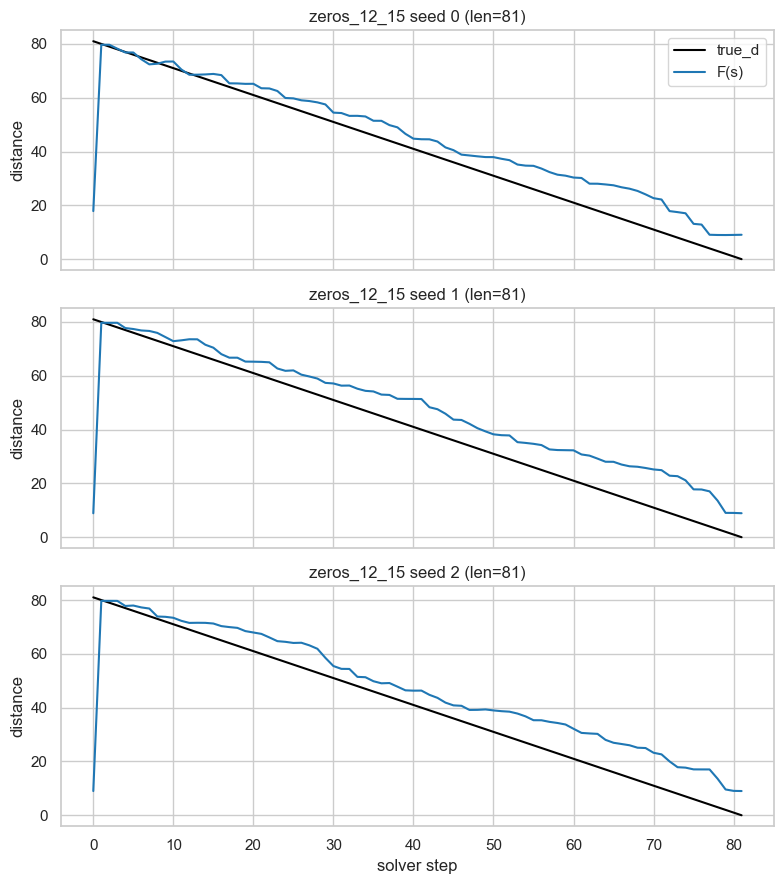

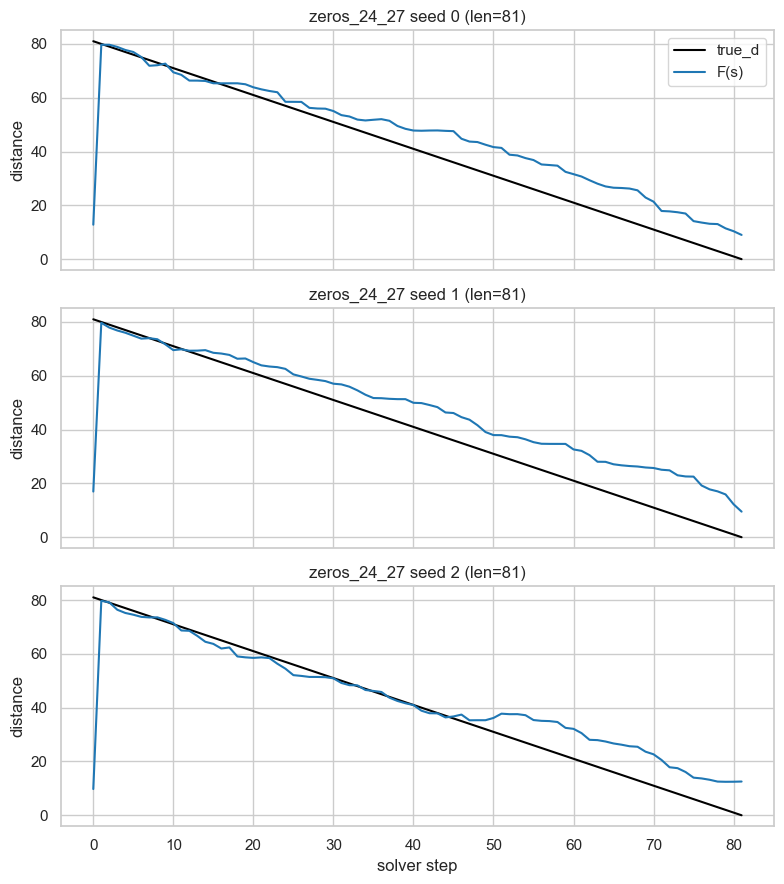

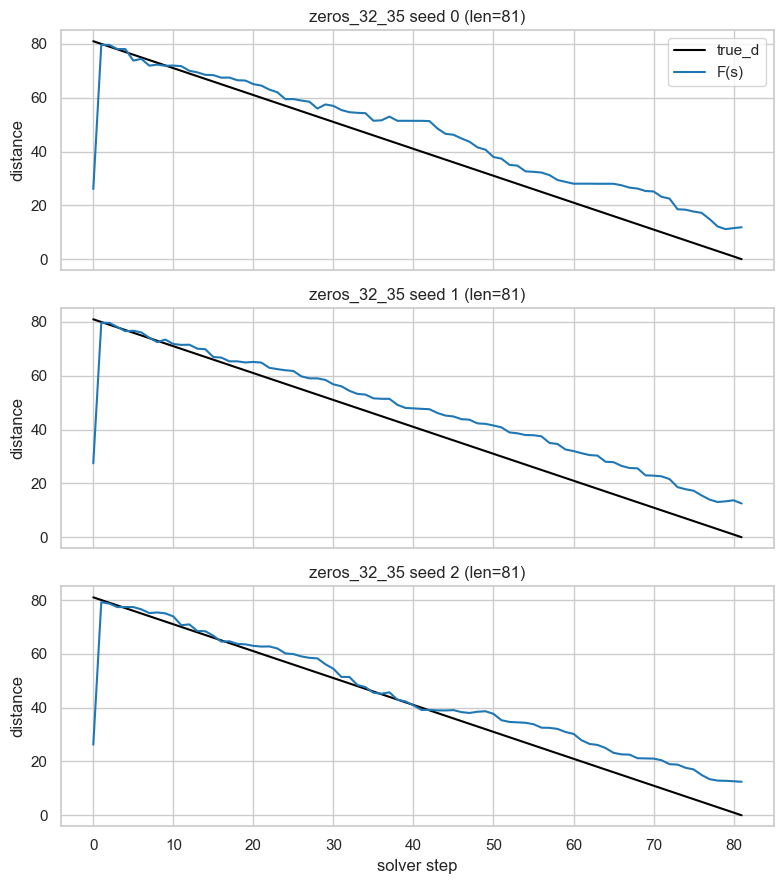

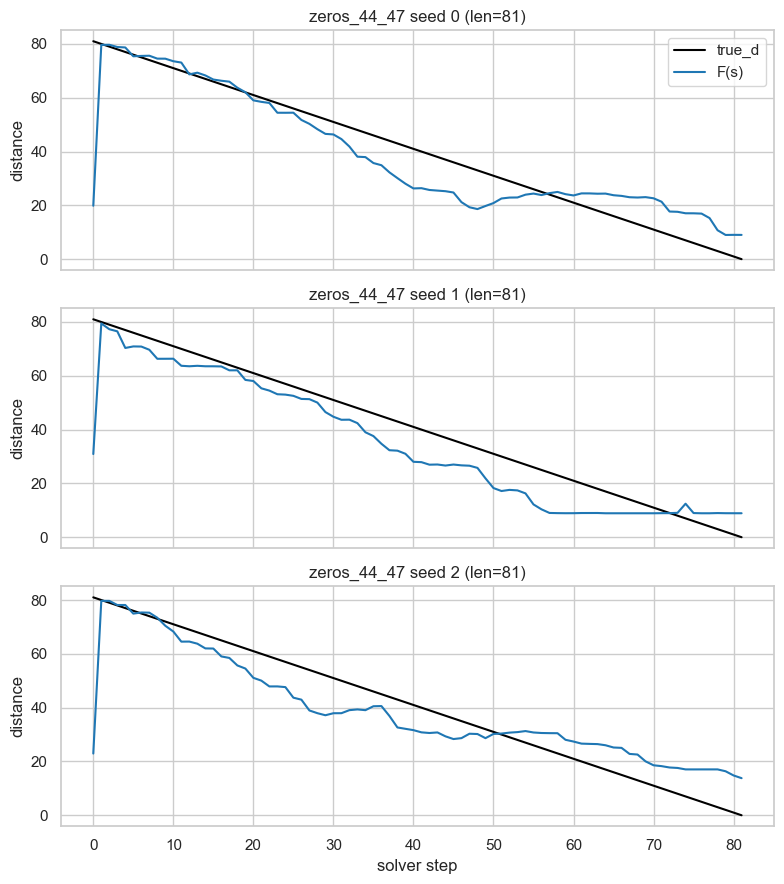

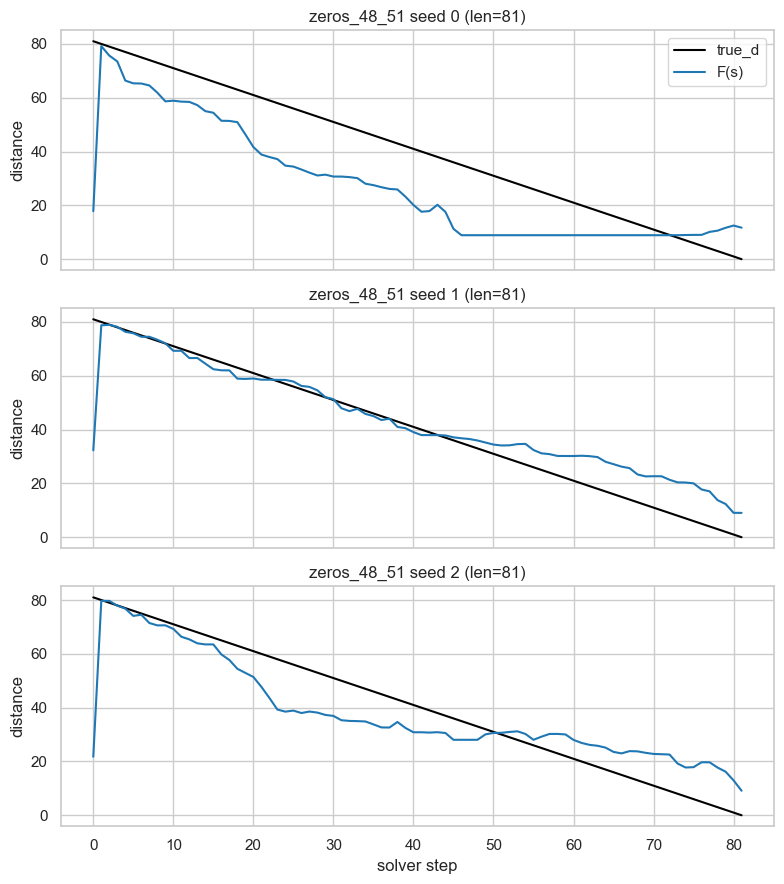

In [21]:
def plot_oracle_calibrated(bin_label, seeds=(0,1,2)):
    fig, axes = plt.subplots(len(seeds), 1, figsize=(8, 3*len(seeds)), sharex=True)
    if len(seeds)==1:
        axes=[axes]
    for ax, seed in zip(axes, seeds):
        trace = oracle_trace(bin_label, seed)
        if trace is None:
            ax.set_title(f"{bin_label} seed {seed}: unsolved")
            continue
        true_d = np.arange(len(trace)-1, -1, -1)
        F = predict_calibrated(trace)
        ax.plot(true_d, label="true_d", color="black")
        ax.plot(F, label="F(s)", color="tab:blue")
        ax.set_ylabel("distance")
        ax.set_title(f"{bin_label} seed {seed} (len={len(trace)-1})")
    axes[-1].set_xlabel("solver step")
    axes[0].legend()
    plt.tight_layout()
    return fig

for b in BIN_LABELS:
    plot_oracle_calibrated(b)
plt.show()

### Calibrated Plot 2 — Scatter true_d vs F(s)

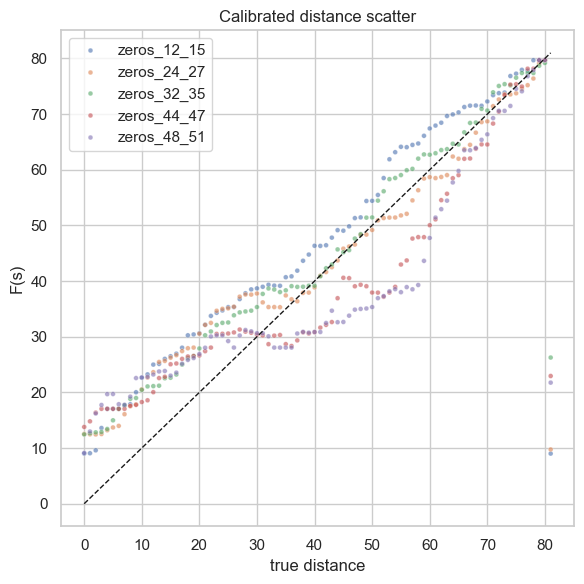

In [22]:
scatter_rows_F = []
for b in BIN_LABELS:
    trace = oracle_trace(b, seed=2)
    if trace is None:
        continue
    true_d = np.arange(len(trace)-1, -1, -1)
    F = predict_calibrated(trace)
    for td, fd in zip(true_d, F):
        scatter_rows_F.append((td, fd, b))
if scatter_rows_F:
    sd, sf, sb = zip(*scatter_rows_F)
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=sd, y=sf, hue=sb, s=12, alpha=0.6)
    m = max(sd)
    plt.plot([0,m],[0,m], color='k', lw=1, ls='--')
    plt.xlabel("true distance")
    plt.ylabel("F(s)")
    plt.title("Calibrated distance scatter")
    plt.tight_layout()
    plt.show()

### Calibrated Plot 3 — Error vs true distance

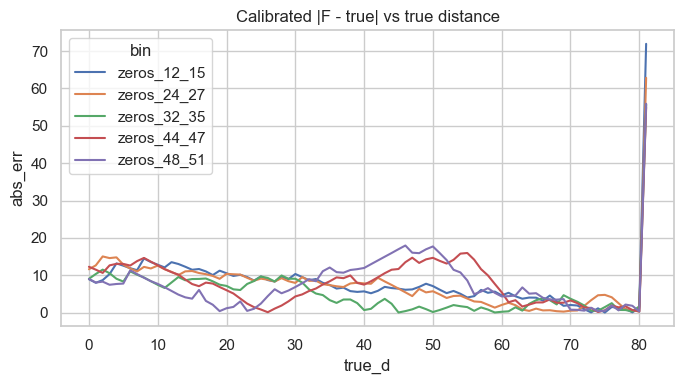

In [23]:
err_rows_F = []
for b in BIN_LABELS:
    trace = oracle_trace(b, seed=3)
    if trace is None:
        continue
    true_d = np.arange(len(trace)-1, -1, -1)
    F = predict_calibrated(trace)
    for td, fd in zip(true_d, F):
        err_rows_F.append({"bin": b, "true_d": td, "abs_err": abs(fd - td)})
err_df_F = pd.DataFrame(err_rows_F)
if not err_df_F.empty:
    plt.figure(figsize=(7,4))
    sns.lineplot(data=err_df_F, x="true_d", y="abs_err", hue="bin")
    plt.title("Calibrated |F - true| vs true distance")
    plt.tight_layout()
    plt.show()

### Calibrated Plot 4 — Var(ΔF) per bin

,bin,var_delta_F,median_abs
0,zeros_12_15,55.846264,0.616934
1,zeros_24_27,49.253880,0.658279
2,zeros_32_35,45.488779,0.664210
3,zeros_44_47,42.126374,0.588352
4,zeros_48_51,41.052223,0.616366


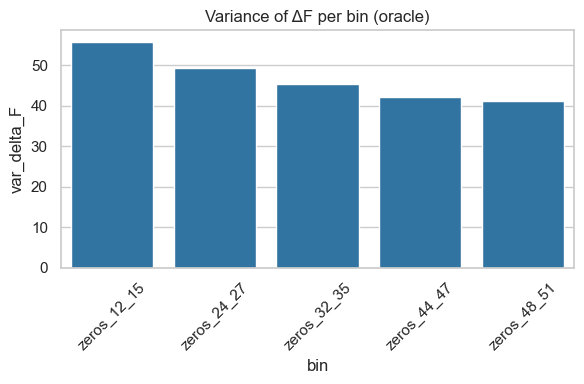

In [24]:
var_rows_F = []
for b in BIN_LABELS:
    dp_list = []
    for seed in range(20):
        trace = oracle_trace(b, seed)
        if trace is None:
            continue
        F = predict_calibrated(trace)
        dp_list.append(F[:-1]-F[1:])
    if dp_list:
        dp = np.concatenate(dp_list)
        var_rows_F.append({"bin": b, "var_delta_F": float(np.var(dp)), "median_abs": float(np.median(np.abs(dp)))})
var_df_F = pd.DataFrame(var_rows_F)
display(var_df_F)
if not var_df_F.empty:
    plt.figure(figsize=(6,4))
    sns.barplot(data=var_df_F, x="bin", y="var_delta_F", color="tab:blue")
    plt.xticks(rotation=45)
    plt.title("Variance of ΔF per bin (oracle)")
    plt.tight_layout()
    plt.show()

### Calibrated Plot 5 — Sum of ΔF along oracle paths

,bin,seed,potential_return,len
0,zeros_12_15,0,8.805198,81
1,zeros_12_15,1,-0.016760,81
2,zeros_12_15,2,-0.006370,81
3,zeros_12_15,3,0.108948,81
4,zeros_12_15,4,7.565439,81
5,zeros_24_27,0,3.803188,81
6,zeros_24_27,1,7.467925,81
7,zeros_24_27,2,-2.790650,81
8,zeros_24_27,3,6.541787,81
9,zeros_24_27,4,8.772810,81


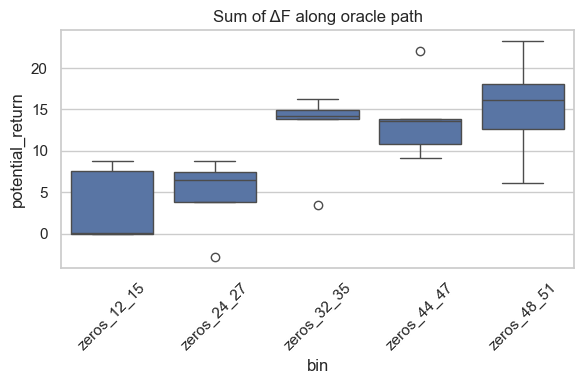

In [25]:
ret_rows_F = []
for b in BIN_LABELS:
    for seed in range(5):
        trace = oracle_trace(b, seed)
        if trace is None:
            continue
        F = predict_calibrated(trace)
        deltas = F[:-1] - F[1:]
        ret_rows_F.append({"bin": b, "seed": seed, "potential_return": deltas.sum(), "len": len(trace)-1})
ret_df_F = pd.DataFrame(ret_rows_F)
display(ret_df_F)
if not ret_df_F.empty:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=ret_df_F, x="bin", y="potential_return")
    plt.xticks(rotation=45)
    plt.title("Sum of ΔF along oracle path")
    plt.tight_layout()
    plt.show()

## Visual diagnostics for \hat{D}(s)

Hero plots to compare distance-to-solve shaping against entropy.

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

def predict_distance(trace_boards):
    boards = np.stack([b.reshape(-1) for b in trace_boards]).astype(np.float32) / 9.0
    with torch.no_grad():
        return dist_model(torch.as_tensor(boards, device=DEVICE)).cpu().numpy()

def oracle_trace(bin_label, seed):
    puzzle, solution = sample_puzzle(bin_label=bin_label, seed=seed, return_solution=True, prev_mix_ratio=0.0)
    trace = solve_with_trace(puzzle)
    return trace

### Plot 1 — Oracle trajectories: true distance vs predicted distance

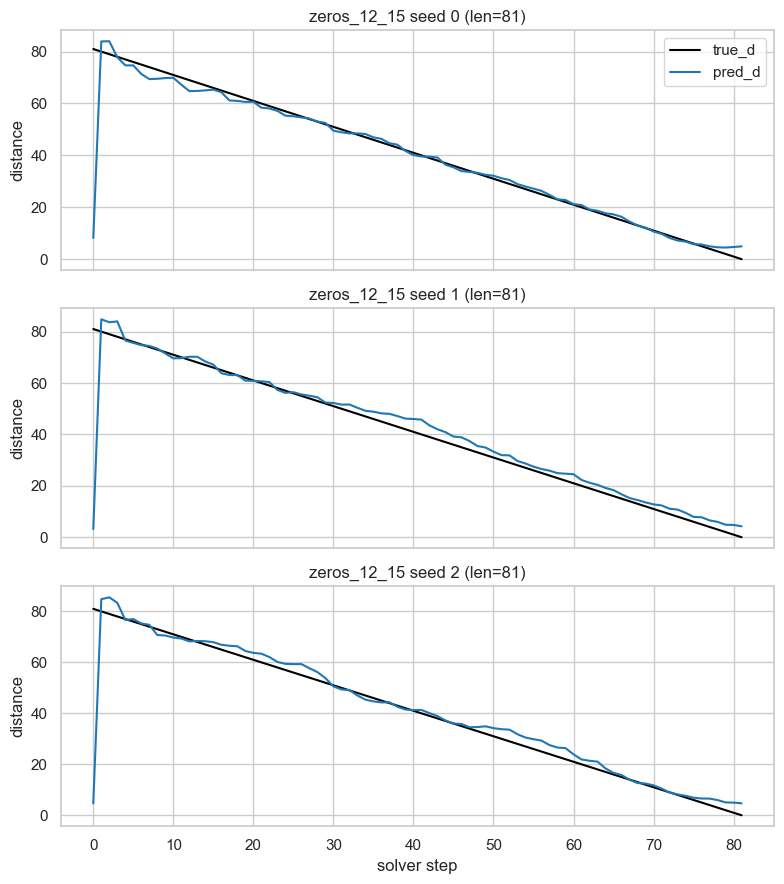

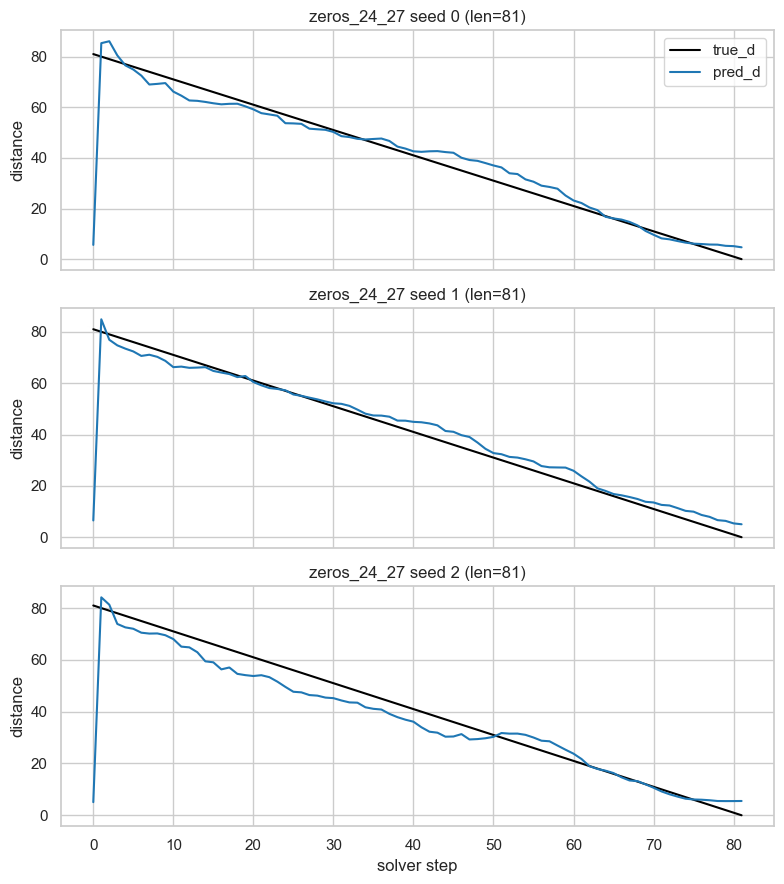

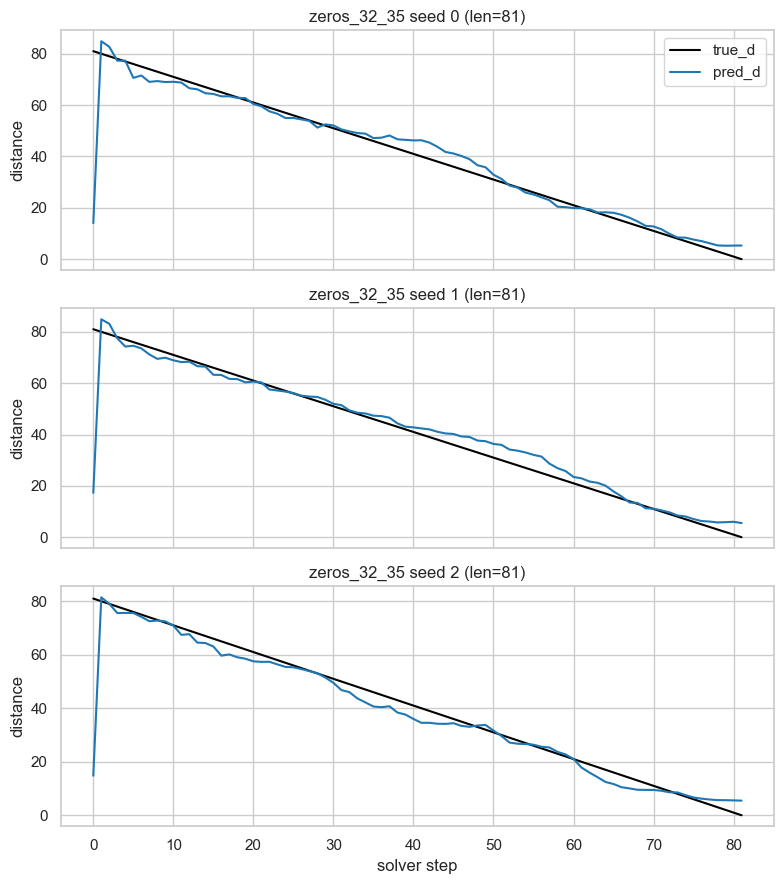

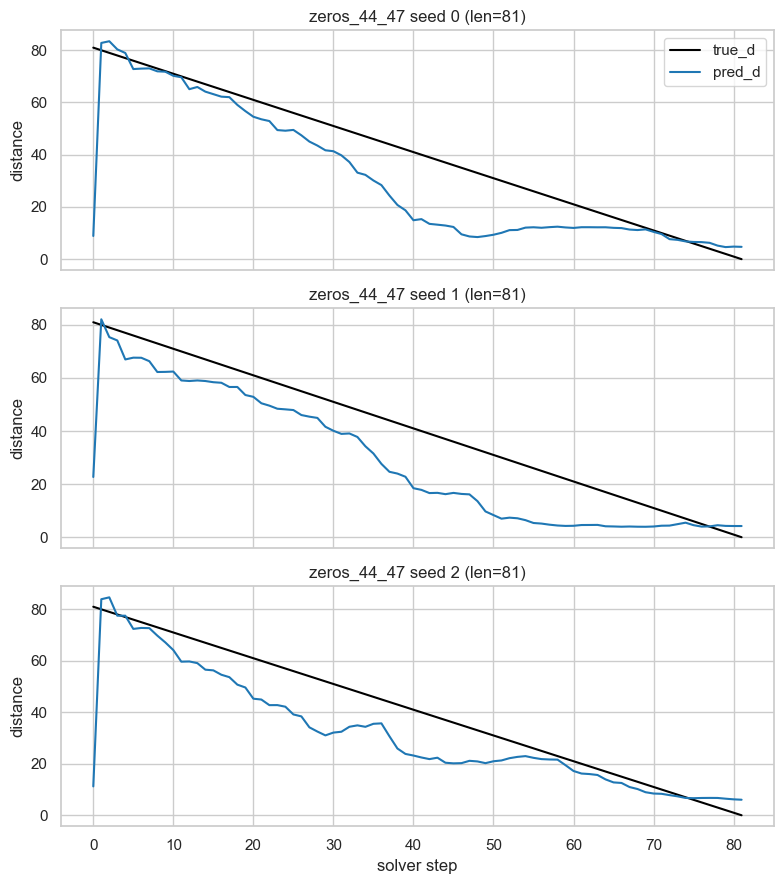

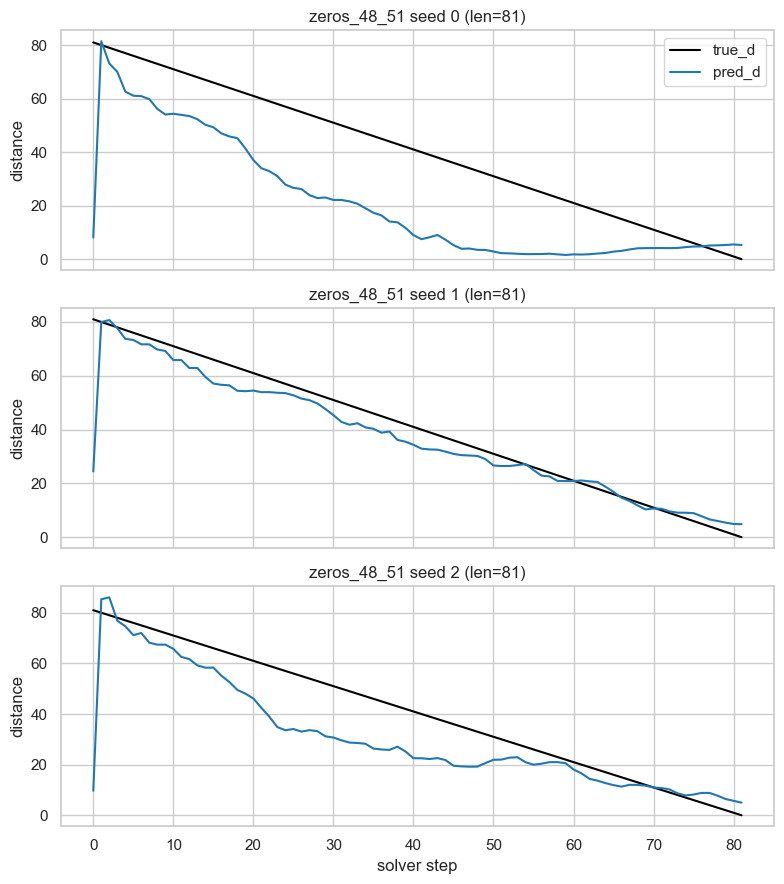

In [27]:
def plot_oracle_hero(bin_label, seeds=(0,1,2)):
    fig, axes = plt.subplots(len(seeds), 1, figsize=(8, 3*len(seeds)), sharex=True)
    if len(seeds)==1:
        axes=[axes]
    for ax, seed in zip(axes, seeds):
        trace = oracle_trace(bin_label, seed)
        if trace is None:
            ax.set_title(f"{bin_label} seed {seed}: unsolved")
            continue
        true_d = np.arange(len(trace)-1, -1, -1)
        pred_d = predict_distance(trace)
        ax.plot(true_d, label="true_d", color="black")
        ax.plot(pred_d, label="pred_d", color="tab:blue")
        ax.set_ylabel("distance")
        ax.set_title(f"{bin_label} seed {seed} (len={len(trace)-1})")
    axes[-1].set_xlabel("solver step")
    axes[0].legend()
    plt.tight_layout()
    return fig

for b in BIN_LABELS:
    plot_oracle_hero(b)
plt.show()

### Plot 2 — Δ\hat{D} vs Δentropy distributions (oracle)

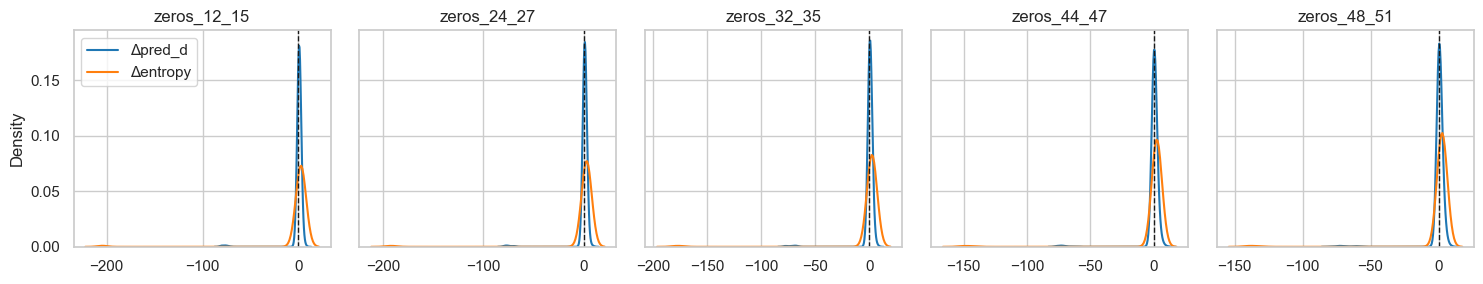

In [28]:
        def delta_distros(bin_label, samples=20):
            deltas_pred, deltas_ent = [], []
            for seed in range(samples):
                trace = oracle_trace(bin_label, seed)
                if trace is None:
                    continue
                ent = [board_entropy(b, entropy_empty_weight=ENTROPY_WEIGHT) for b in trace]
                pred = predict_distance(trace)
                deltas_pred.append(pred[:-1]-pred[1:])
                deltas_ent.append(np.array(ent[:-1])-np.array(ent[1:]))
            if not deltas_pred:
                return None, None
            return np.concatenate(deltas_pred), np.concatenate(deltas_ent)

        fig, axes = plt.subplots(1, len(BIN_LABELS), figsize=(3*len(BIN_LABELS), 3), sharey=True)
        for ax, b in zip(axes, BIN_LABELS):
            dp, de = delta_distros(b, samples=20)
            if dp is None:
                ax.set_title(f"{b}no data")
                continue
            sns.kdeplot(dp, ax=ax, label="Δpred_d", color="tab:blue")
            sns.kdeplot(de, ax=ax, label="Δentropy", color="tab:orange")
            ax.axvline(0, color="k", lw=1, ls="--")
            ax.set_title(b)
        axes[0].legend()
        plt.tight_layout()
        plt.show()

### Plot 3 — Agent trajectories: cumulative Δ\hat{D} (success vs failure)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:35                                                                                   │
│                                                                                                  │
│   32 │   return fig                                                                              │
│   33                                                                                             │
│   34 for b in BIN_LABELS:                                                                        │
│ ❱ 35 │   plot_agent_cum(b, episodes=3)                                                           │
│   36 plt.show()                                                                                  │
│   37                                                                                             │
│                                                                                                  │
│ in plot_agent_cum:22                                                                             │
│                                                                                                  │
│   19 def plot_agent_cum(bin_label, episodes=5):                                                  │
│   20 │   fig, ax = plt.subplots(figsize=(6,4))                                                   │
│   21 │   for seed in range(episodes):                                                            │
│ ❱ 22 │   │   preds, solved = run_agent_episode_with_pred(policy, bin_label, seed=seed, greedy    │
│   23 │   │   deltas = np.array(preds[:-1]) - np.array(preds[1:])                                 │
│   24 │   │   cum = np.cumsum(-deltas)                                                            │
│   25 │   │   style = '-' if solved else '--'                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'policy' is not defined

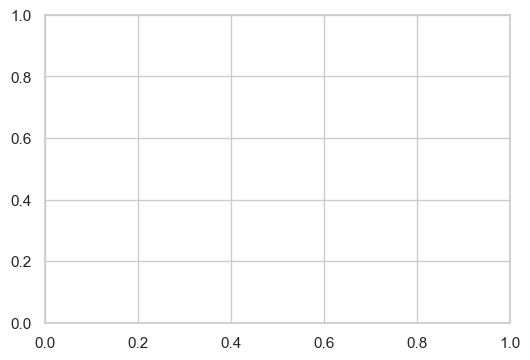

In [29]:
def run_agent_episode_with_pred(policy, bin_label: str, seed: int, greedy: bool = True, max_steps: int = MAX_STEPS):
    puzzle, solution = sample_puzzle(bin_label=bin_label, seed=seed, return_solution=True, prev_mix_ratio=0.0)
    env = SudokuEnv(puzzle, solution, max_steps=max_steps)
    obs = env.reset(initial_board=puzzle, solution_board=solution)
    preds = [float(dist_model(torch.as_tensor(obs.reshape(1,-1)/9.0, device=DEVICE)).item())]
    info = {}
    for _ in range(max_steps):
        obs_flat = torch.as_tensor(obs.reshape(1, -1), dtype=torch.float32, device=DEVICE)
        with torch.no_grad():
            logits, _ = policy.forward_eval(obs_flat)
            action = torch.argmax(logits, dim=1) if greedy else torch.distributions.Categorical(logits=logits).sample()
        obs, reward, done, info = env.step(int(action.item()))
        preds.append(float(dist_model(torch.as_tensor(obs.reshape(1,-1)/9.0, device=DEVICE)).item()))
        if done:
            break
    solved = bool(info.get("solved", False))
    return preds, solved

def plot_agent_cum(bin_label, episodes=5):
    fig, ax = plt.subplots(figsize=(6,4))
    for seed in range(episodes):
        preds, solved = run_agent_episode_with_pred(policy, bin_label, seed=seed, greedy=True)
        deltas = np.array(preds[:-1]) - np.array(preds[1:])
        cum = np.cumsum(-deltas)
        style = '-' if solved else '--'
        ax.plot(cum, style, label=f"seed {seed} {'success' if solved else 'fail'}")
    ax.set_title(f"{bin_label}: cumulative -Δpred_d")
    ax.set_xlabel("step")
    ax.set_ylabel("cumulative progress")
    ax.legend(fontsize=8)
    plt.tight_layout()
    return fig

for b in BIN_LABELS:
    plot_agent_cum(b, episodes=3)
plt.show()

### Plot 4 — Per-bin variance of Δ\hat{D} (oracle)

In [30]:
var_rows = []
for b in BIN_LABELS:
    dp, _ = delta_distros(b, samples=30)
    if dp is None:
        continue
    var_rows.append({"bin": b, "var_delta_pred": float(np.var(dp)), "median_abs": float(np.median(np.abs(dp)))})
var_df = pd.DataFrame(var_rows)
display(var_df)
plt.figure(figsize=(6,4))
sns.barplot(data=var_df, x="bin", y="var_delta_pred", color="tab:blue")
plt.xticks(rotation=45)
plt.title("Variance of Δpred per bin (oracle traces)")
plt.tight_layout()
plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│    1 var_rows = []                                                                               │
│    2 for b in BIN_LABELS:                                                                        │
│ ❱  3 │   dp, _ = delta_distros(b, samples=30)                                                    │
│    4 │   if dp is None:                                                                          │
│    5 │   │   continue                                                                            │
│    6 │   var_rows.append({"bin": b, "var_delta_pred": float(np.var(dp)), "median_abs": float(    │
│                                                                                                  │
│ in delta_distros:10                                                                              │
│                                                                                                  │
│    7 │   │   ent = [board_entropy(b, entropy_empty_weight=ENTROPY_WEIGHT) for b in trace]        │
│    8 │   │   pred = predict_distance(trace)                                                      │
│    9 │   │   deltas_pred.append(pred[:-1]-pred[1:])                                              │
│ ❱ 10 │   │   deltas_ent.append(np.array(ent[:-1])-np.array(ent[1:]))                             │
│   11 │   if not deltas_pred:                                                                     │
│   12 │   │   return None, None                                                                   │
│   13 │   return np.concatenate(deltas_pred), np.concatenate(deltas_ent)                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeWarning: invalid value encountered in subtract

### Plot 5 — Scatter: true distance vs predicted (all bins)

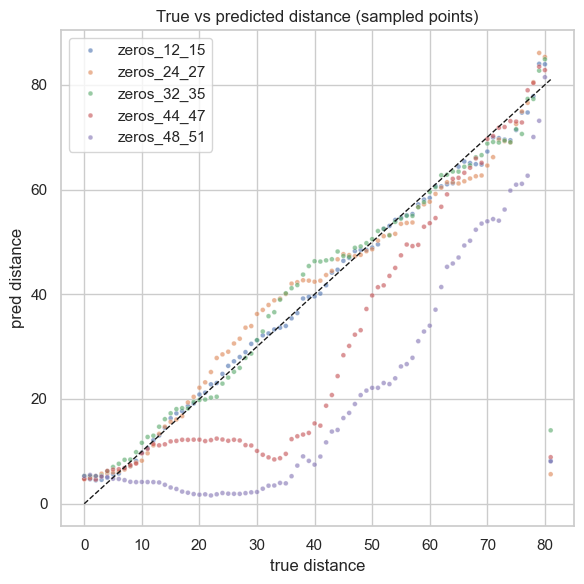

In [31]:
scatter_rows = []
max_points = 5000
rng = np.random.default_rng(0)
for b in BIN_LABELS:
    trace = oracle_trace(b, seed=0)
    if trace is None:
        continue
    true_d = np.arange(len(trace)-1, -1, -1)
    preds = predict_distance(trace)
    for t, p in zip(true_d, preds):
        scatter_rows.append((t, p, b))
if len(scatter_rows) > max_points:
    scatter_rows = rng.choice(scatter_rows, size=max_points, replace=False)
sd, sp, sb = zip(*scatter_rows)
plt.figure(figsize=(6,6))
sns.scatterplot(x=sd, y=sp, hue=sb, s=12, alpha=0.6)
plt.plot([0, max(sd)], [0, max(sd)], color='k', lw=1, ls='--')
plt.xlabel("true distance")
plt.ylabel("pred distance")
plt.title("True vs predicted distance (sampled points)")
plt.tight_layout()
plt.show()

### Error profile vs true distance

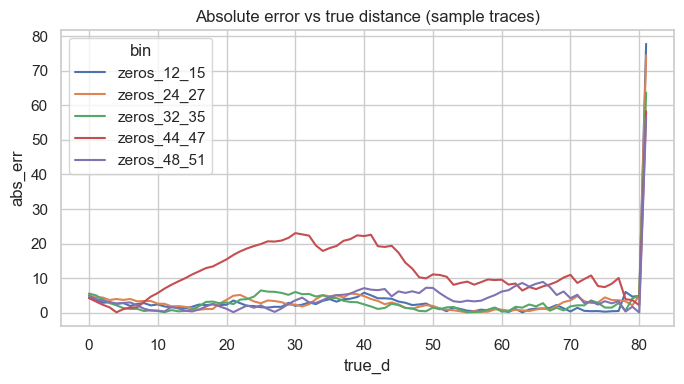

In [32]:
err_rows = []
for b in BIN_LABELS:
    trace = oracle_trace(b, seed=1)
    if trace is None:
        continue
    true_d = np.arange(len(trace)-1, -1, -1)
    preds = predict_distance(trace)
    for td, pd_ in zip(true_d, preds):
        err_rows.append({"bin": b, "true_d": td, "abs_err": abs(pd_ - td)})
err_df = pd.DataFrame(err_rows)
plt.figure(figsize=(7,4))
sns.lineplot(data=err_df, x="true_d", y="abs_err", hue="bin")
plt.title("Absolute error vs true distance (sample traces)")
plt.tight_layout()
plt.show()

### Potential-shaped return on oracle paths

,bin,seed,potential_return,len
0,zeros_12_15,0,3.241158,81
1,zeros_12_15,1,-1.082655,81
2,zeros_12_15,2,-0.030000,81
3,zeros_12_15,3,0.513146,81
4,zeros_12_15,4,1.581391,81
5,zeros_24_27,0,0.951376,81
6,zeros_24_27,1,1.489335,81
7,zeros_24_27,2,-0.446837,81
8,zeros_24_27,3,3.010061,81
9,zeros_24_27,4,3.262300,81


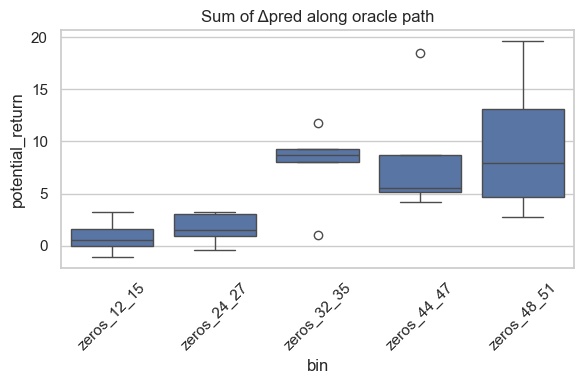

In [33]:
ret_rows = []
for b in BIN_LABELS:
    for seed in range(5):
        trace = oracle_trace(b, seed)
        if trace is None:
            continue
        preds = predict_distance(trace)
        deltas = preds[:-1] - preds[1:]
        ret = deltas.sum()
        ret_rows.append({"bin": b, "seed": seed, "potential_return": ret, "len": len(trace)-1})
ret_df = pd.DataFrame(ret_rows)
display(ret_df)
plt.figure(figsize=(6,4))
sns.boxplot(data=ret_df, x="bin", y="potential_return")
plt.xticks(rotation=45)
plt.title("Sum of Δpred along oracle path")
plt.tight_layout()
plt.show()